In [178]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('RRCA_baseflow.csv')
df.head()
num_days_since_zero = 738598 + 365
num_days_since_1900 = 45003
offset = num_days_since_zero - num_days_since_1900
df['days_since_1900'] = df.Date - offset
pd.period_range("1215-01-01", "1381-01-01", freq="D")
period = pd.Period('1900-1-1', freq='D') - pd.Period('0001-2-1', freq='D')


# num_days_since_zero = 738598 + 366
# num_days_since_1900 = 45003
# offset = num_days_since_zero - num_days_since_1900
offset = 693595 + 368
# offset = 693564
df['days_since_1900'] = df.Date - offset
df['date'] = pd.to_datetime(df.days_since_1900.astype('int'), unit='D', origin=pd.Timestamp('1900-01-01'))
df.loc[0,'date'].month
df['year'] = df.date.apply(lambda x:pd.to_datetime(x).year)
df['month'] = df.date.apply(lambda x:pd.to_datetime(x).month)
df['day'] = df.date.apply(lambda x:pd.to_datetime(x).day)

##cut out all miscalculated data
df = df[df.year > 1950]

##Keeeping original dataset just in case
og_df = df

##FOLLOWING CODE DOESN'T MATTER, I WAS JUST PLAYING AROUND
##WILL INCLUDE FAILURES IN REPORT

##------------------------------------------------------------------------------------------------


##Attempt to classify item

# Define a function to map months to seasons
def map_month_to_season(month):
    if month in [12, 1, 2]:  # Winter
        return 1
    elif month in [3, 4, 5]:  # Spring
        return 2
    elif month in [6, 7, 8]:  # Summer
        return 3
    else:  # Fall
        return 4

def map_precipitation_to_entry(Precipitation):
    if Precipitation < 5:
        return 1
    else:
        return 0

def map_Irrigation_pumping_to_entry(Irrigation_pumping):
    ##high flow
    if Irrigation_pumping < -1:
        return 2
    ##low flow
    elif  Irrigation_pumping < 0:
        return 1
    ##no flow
    else: return 0

# Apply the function to create a new column for seasons
df['season'] = df['month'].apply(map_month_to_season)
df['isDry'] = df['Precipitation'].apply(map_precipitation_to_entry)
df['isPumping'] = df['Irrigation_pumping'].apply(map_Irrigation_pumping_to_entry)
df

,Date,Segment_id,x,y,Evapotranspiration,Precipitation,Irrigation_pumping,Observed,days_since_1900,date,year,month,day,season,isDry,isPumping
50,712617,144,1086190,14476800,1.09,24.91,0.0,3.915254,18654,1951-01-28,1951,1,28,1,0,0
51,712648,144,1086190,14476800,1.53,24.91,0.0,5.915254,18685,1951-02-28,1951,2,28,1,0,0
52,712678,144,1086190,14476800,2.50,24.91,0.0,8.426229,18715,1951-03-30,1951,3,30,2,0,0
53,712709,144,1086190,14476800,5.95,24.91,0.0,11.426229,18746,1951-04-30,1951,4,30,2,0,0
54,712739,144,1086190,14476800,5.88,24.91,0.0,13.435000,18776,1951-05-30,1951,5,30,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15586,721810,98,721870,14387040,0.00,0.00,0.0,0.298500,27847,1976-03-30,1976,3,30,2,1,0
15587,721841,98,721870,14387040,0.00,0.00,0.0,0.211475,27878,1976-04-30,1976,4,30,2,1,0
15588,721871,98,721870,14387040,0.00,0.00,0.0,0.122951,27908,1976-05-30,1976,5,30,2,1,0
15589,721902,98,721870,14387040,0.00,0.00,0.0,0.120000,27939,1976-06-30,1976,6,30,3,1,0


In [179]:
# Group the data by Year and calculate the average of all columns except x, y, Segment_ID, and Date
avg_yearly_data = df.groupby('year').agg({'Evapotranspiration':'mean', 
                                          'Precipitation':'mean', 
                                          'Irrigation_pumping':'mean', 
                                          'Observed':'mean'})

# Reset the index to make Year a column instead of the index
avg_yearly_data.reset_index(inplace=True)

# Display the remodeled data
avg_yearly_data
df = avg_yearly_data

<Axes: xlabel='Irrigation_pumping', ylabel='year'>

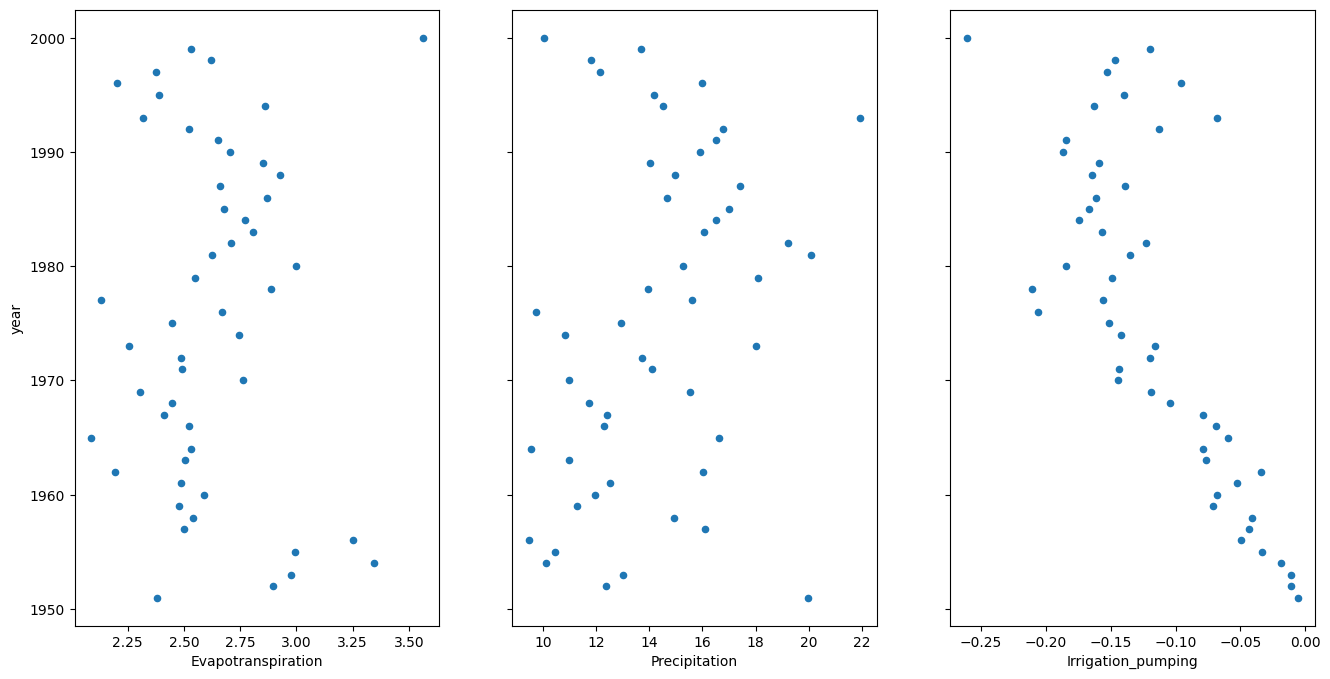

In [180]:
##display scatter plots for values
fig, axs = plt.subplots(1, 3, sharey=True)
df.plot(kind='scatter', y='year', x='Evapotranspiration', ax=axs[0], figsize=(16, 8))
df.plot(kind='scatter', y='year', x='Precipitation', ax=axs[1])
df.plot(kind='scatter', y='year', x='Irrigation_pumping', ax=axs[2])

<Axes: xlabel='Observed', ylabel='year'>

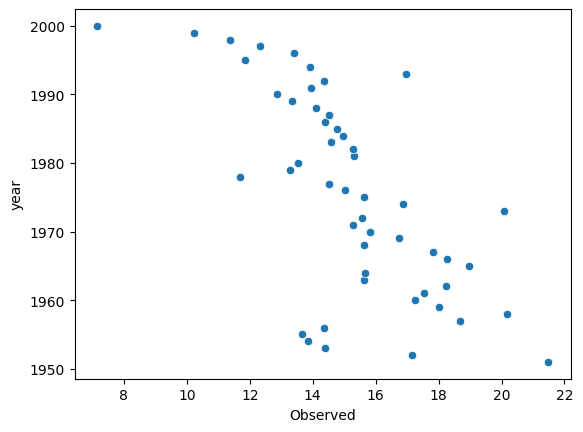

In [181]:
##display scatter plots for values (cont.)
sns.scatterplot(data=df, y='year', x='Observed')

<Axes: xlabel='x', ylabel='y'>

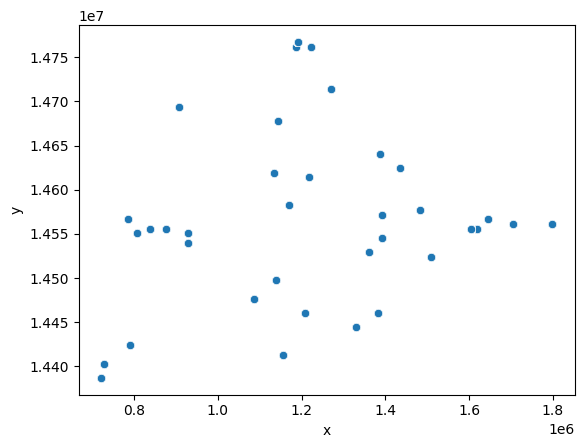

In [182]:
##map out x and y vals 'cause why not
sns.scatterplot(data=og_df,x='x',y='y')

Mean Squared Error: 2.111750229856588
R-squared: 0.7608082667917825


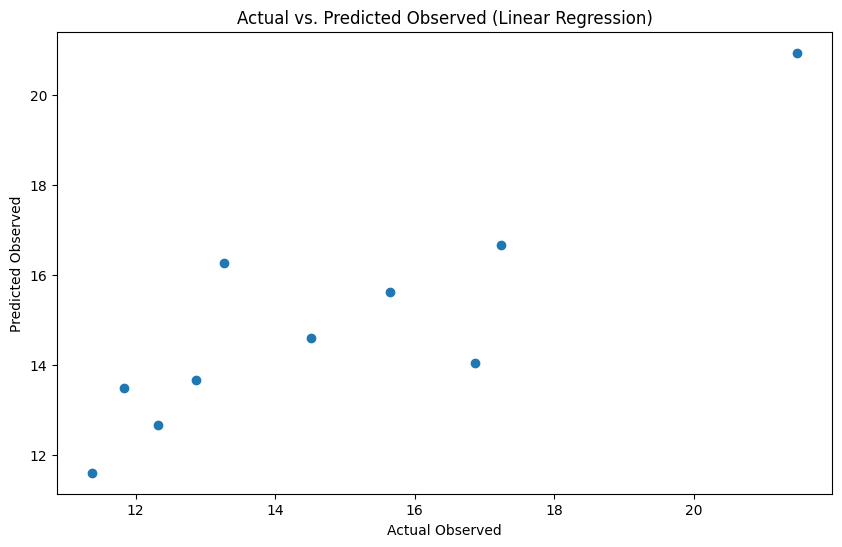

In [183]:
##linear regression section

##high score with seed 2 is:
## Mean Squared Error: 2.111750229856588
## R-squared: 0.7608082667917825

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Define the predictor variables (features) and the target variable
##X = df[['y','x','Segment_id','Evapotranspiration', 'isDry','season','year','isPumping']]

#X= avg_yearly_data[['Precipitation','Irrigation_pumping']]
X= avg_yearly_data[['Precipitation','Irrigation_pumping','year','Evapotranspiration']]

##target
y =  avg_yearly_data['Observed']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=2)

# Create a linear regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict on the testing data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Plotting predicted vs. actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Observed")
plt.ylabel("Predicted Observed")
plt.title("Actual vs. Predicted Observed (Linear Regression)")
plt.show()

Correlation Matrix:
                        year  Evapotranspiration  Precipitation  \
year                1.000000            0.011979       0.285708   
Evapotranspiration  0.011979            1.000000      -0.398365   
Precipitation       0.285708           -0.398365       1.000000   
Irrigation_pumping -0.759380           -0.216181      -0.048252   
Observed           -0.669305           -0.509095       0.241120   

                    Irrigation_pumping  Observed  
year                         -0.759380 -0.669305  
Evapotranspiration           -0.216181 -0.509095  
Precipitation                -0.048252  0.241120  
Irrigation_pumping            1.000000  0.627834  
Observed                      0.627834  1.000000  


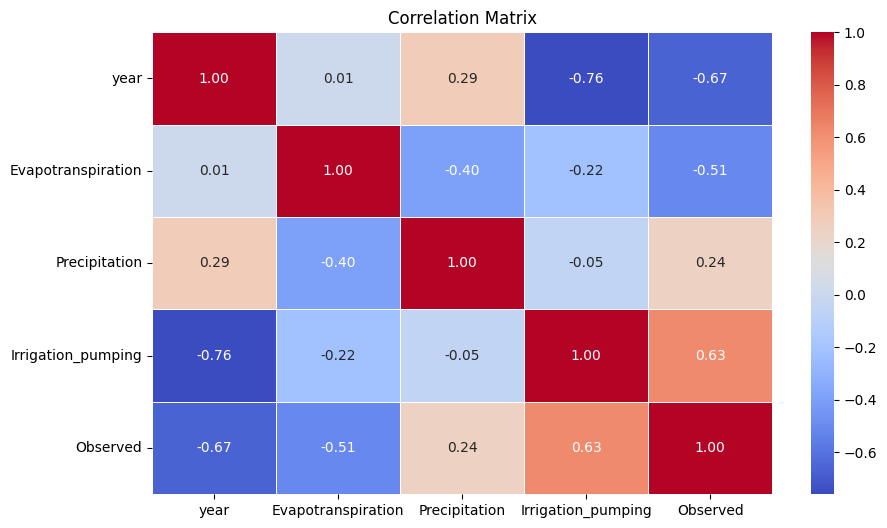

In [184]:
##looks for correlation across all variables


# Compute the correlation matrix
correlation_matrix = df.corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

import seaborn as sns
import matplotlib.pyplot as plt

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

<Axes: xlabel='Irrigation_pumping', ylabel='Observed'>

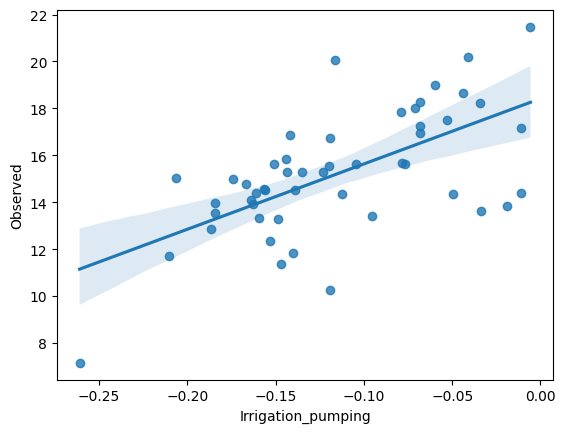

In [185]:
##Display regplots to show coorelation 

sns.regplot(data=df, x='Irrigation_pumping', y='Observed')

<Axes: xlabel='Precipitation', ylabel='Observed'>

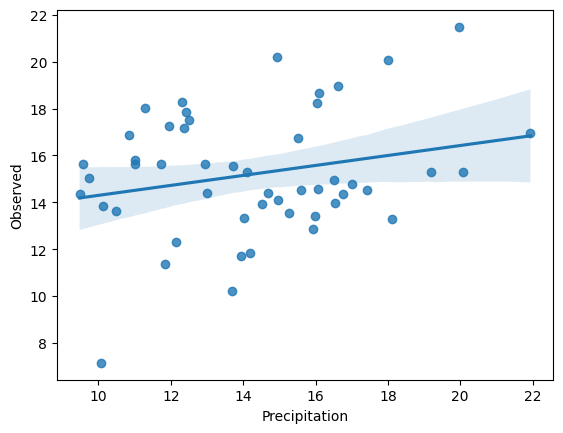

In [186]:
sns.regplot(data=df, x='Precipitation', y='Observed')

<Axes: xlabel='Evapotranspiration', ylabel='Observed'>

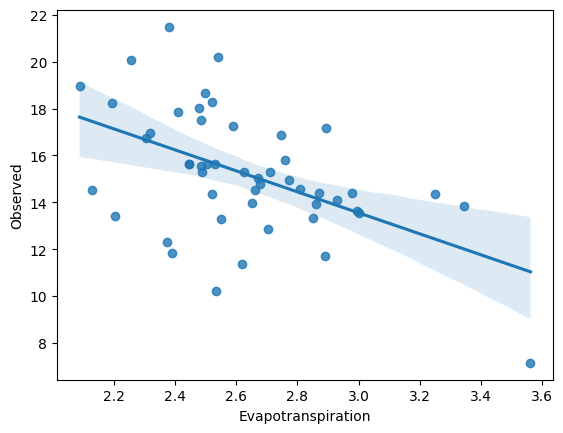

In [187]:
sns.regplot(data=df, x='Evapotranspiration', y='Observed')

<Axes: xlabel='year', ylabel='Observed'>

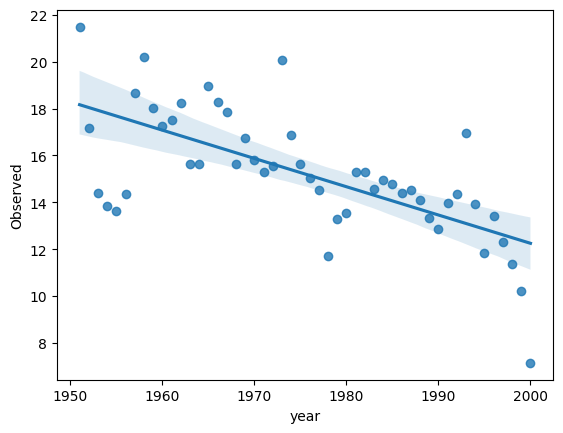

In [188]:
sns.regplot(data=df, x='year', y='Observed')